In [1]:
import numpy as np
import pandas as pd
import torch 
import os, glob
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torch import nn
import matplotlib.pyplot as plt

In [2]:
# get data in format necessary for library
def CreateLabelsFrom1DNumpy(numpy_labels,n_cat=4):
    one_hot_labels = torch.zeros(len(numpy_labels),n_cat)
    for idx,label in enumerate(numpy_labels):
        one_hot_labels[idx,label-1]=1

    return one_hot_labels

In [3]:
# define network
class NeuralNetwork(nn.Module):
    def __init__(self,n_hidden_units=2):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.layer_stack = nn.Sequential(
            nn.Linear(2, n_hidden_units),
            nn.Softplus(),
            nn.Linear(n_hidden_units, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layer_stack(x)
        return logits

In [4]:
# for convergence
def moving_average(x, w):
    #https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-numpy-scipy
    return np.convolve(x, np.ones(w), 'valid') / w


In [5]:
def train_loop(dataloader, model, loss_fn, optimizer, leave_out_idx=0):
    #copied from tutorial: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        if batch != leave_out_idx:
            # Compute prediction and loss
            pred = model(X.float())#convert X to float 32 not 64
            loss = loss_fn(pred, y.float().reshape(100,1))
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def test_loop(dataloader, model, loss_fn, leave_out_idx=0):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
         for batch, (X, y) in enumerate(dataloader):
            if batch == leave_out_idx:
                size = len(X)
                pred = model(X.float())
                loss = loss_fn(pred, y.float().reshape(100,1))

    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return loss

# Cross Validate N Perceptrons

100
-----------------n perceptrons 1 -----------
9.597006321907044


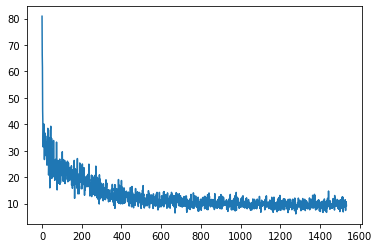

9.560121518135071


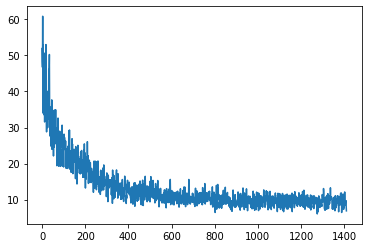

9.535613342285156


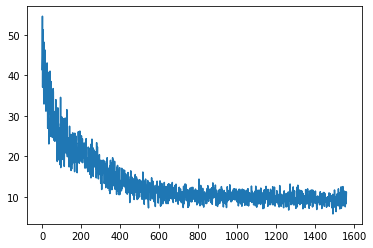

9.436119555473327


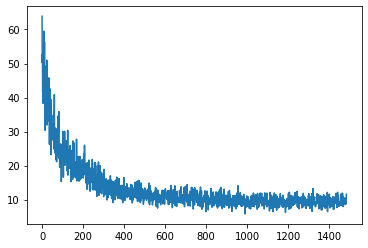

9.54940018081665


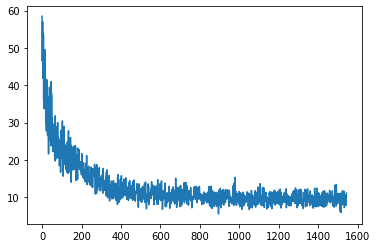

9.690437167167664


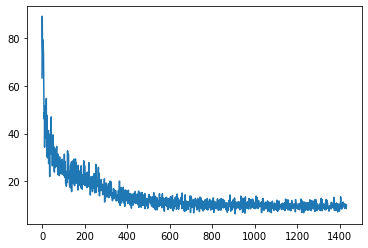

9.746469700813293


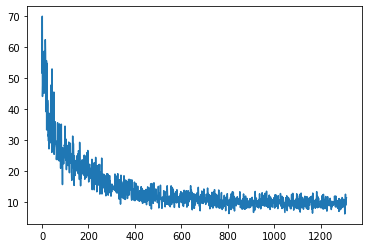

9.854938772201539


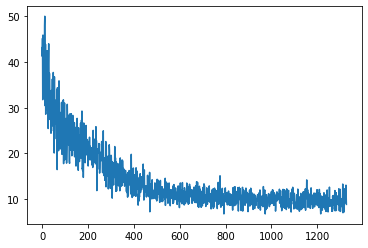

9.506052292823792


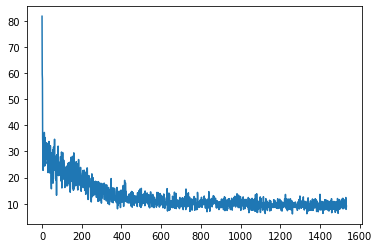

9.79668863773346


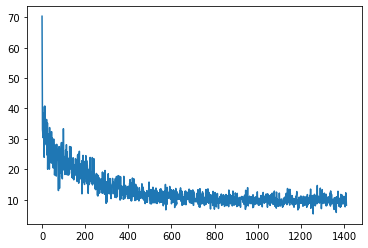

-----------------n perceptrons 2 -----------
4.307957461833954


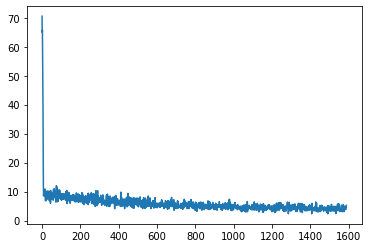

4.233776794910431


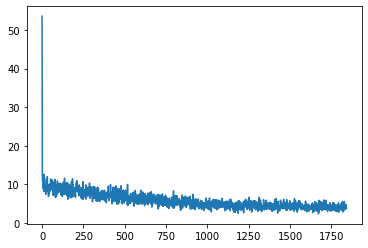

9.512193446159364


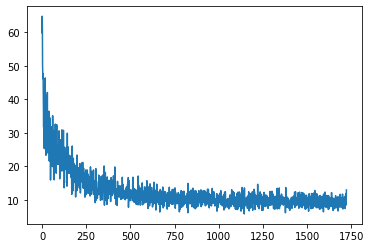

9.355176912307739


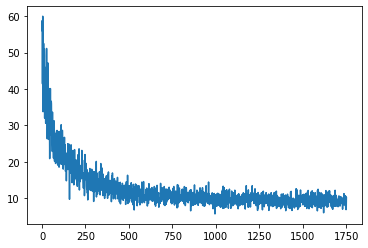

4.23682061290741


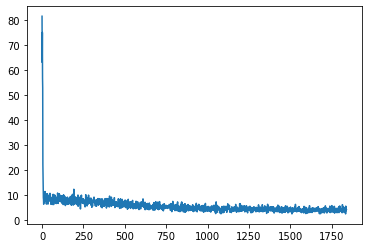

9.811888077735901


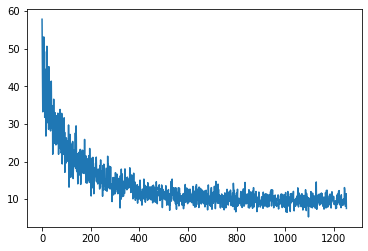

9.516069989204407


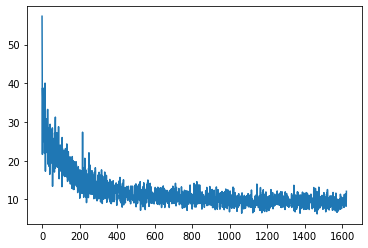

4.30046671628952


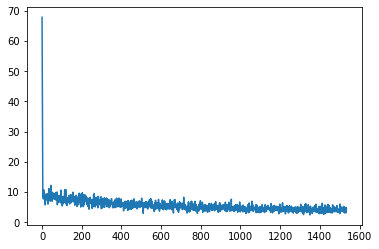

9.948302636146545


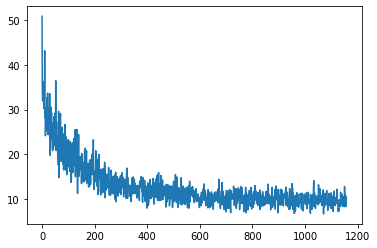

4.164101394176483


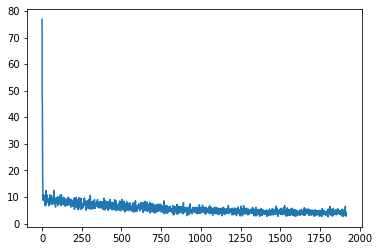

-----------------n perceptrons 4 -----------
4.258349905490875


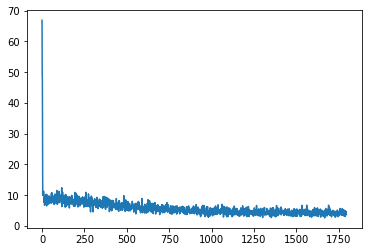

4.1376646699905395


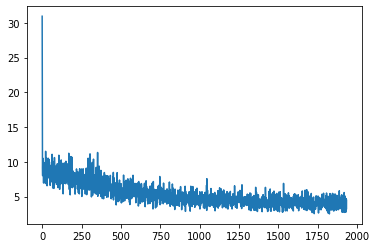

4.212580665588379


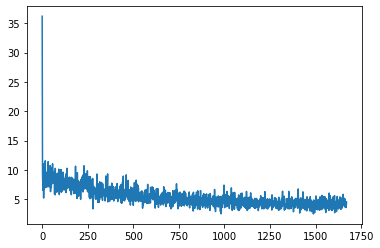

4.371850074291229


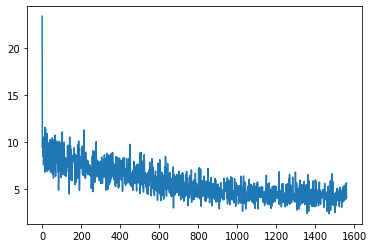

4.444433664798736


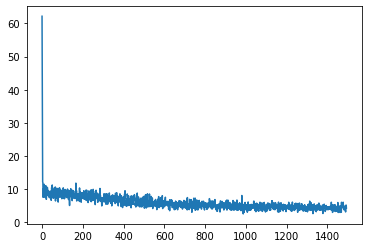

4.24238143825531


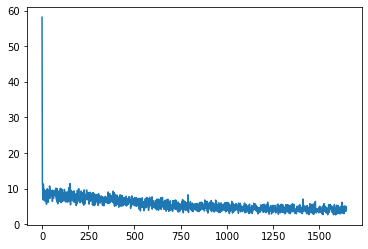

4.258370309829712


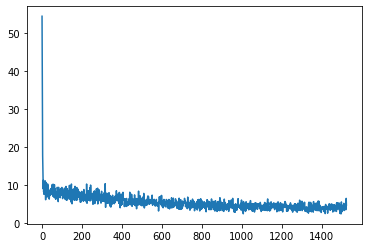

10.03922101020813


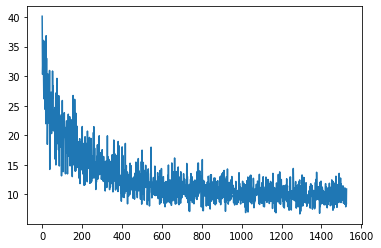

4.269254853248596


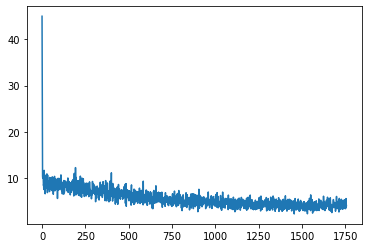

4.169054651737214


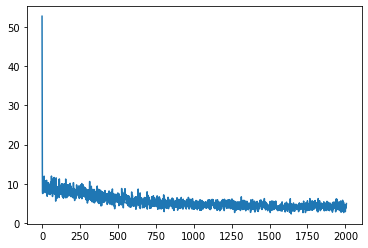

-----------------n perceptrons 5 -----------
4.117957853317261


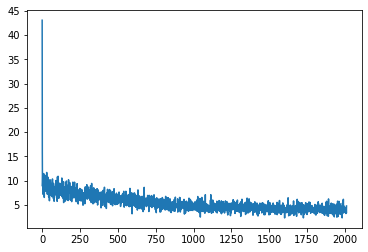

4.570625271320343


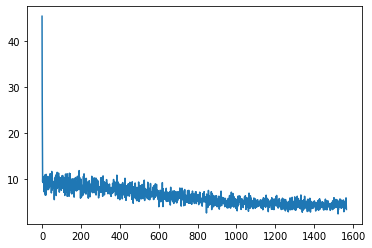

4.301465991020202


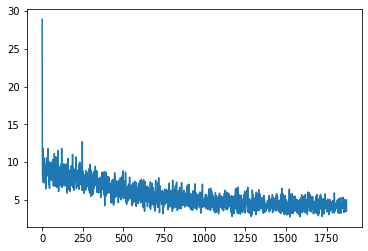

4.577687842369079


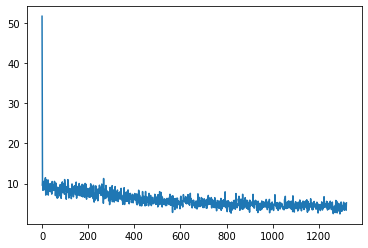

4.360623258113861


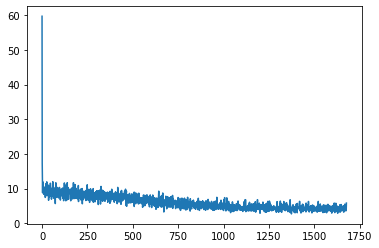

4.285755823135376


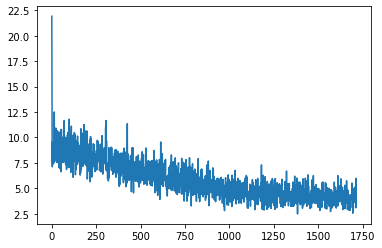

4.334011145114899


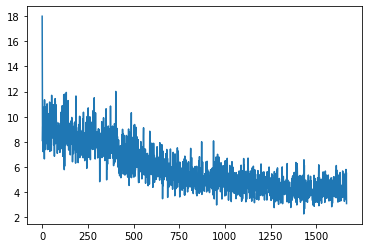

4.321914042949676


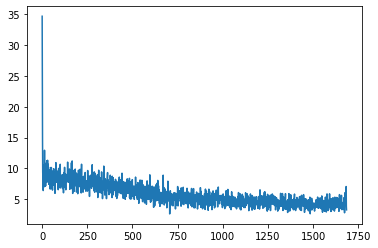

4.1598564205169675


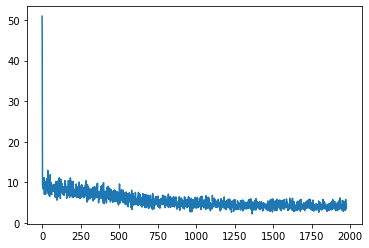

4.224120677947998


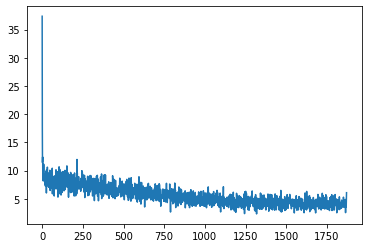

-----------------n perceptrons 6 -----------
4.180398607254029


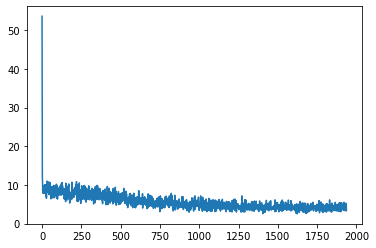

4.3961594529151915


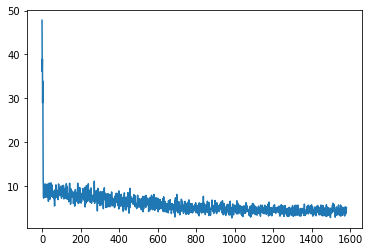

4.312452790260315


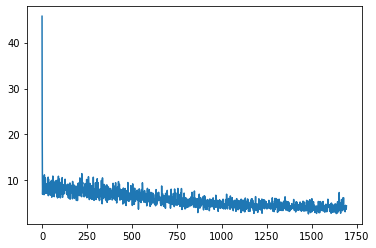

4.460455862522125


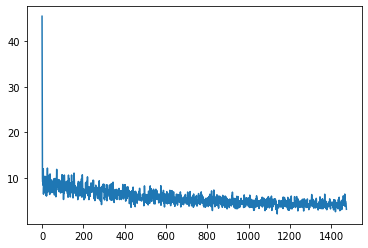

4.163779030799866


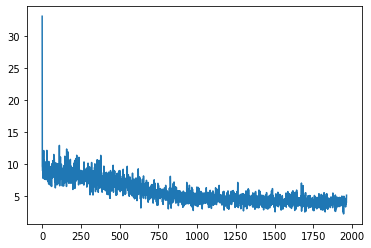

4.362169222831726


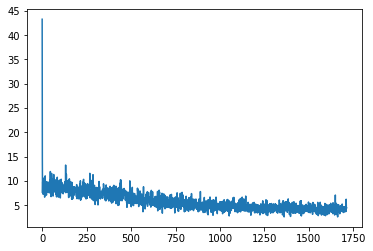

4.24720145702362


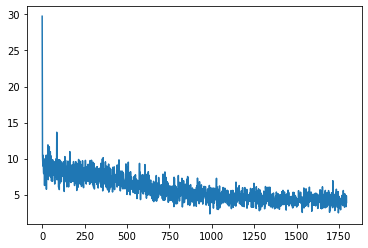

4.414840378284454


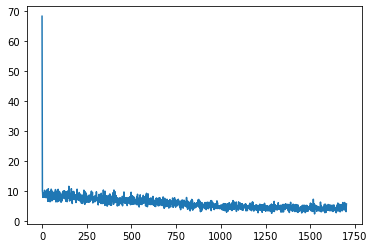

4.258240424156189


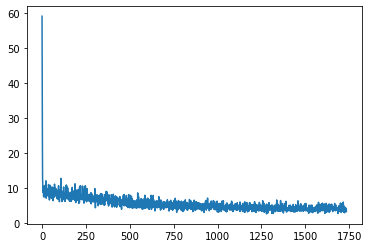

4.192098958492279


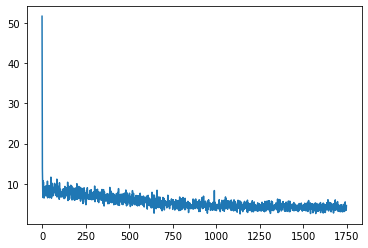

-----------------n perceptrons 7 -----------
4.290761875152588


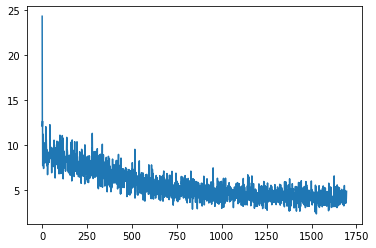

4.738482339382172


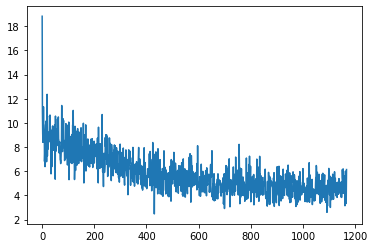

4.300908699989319


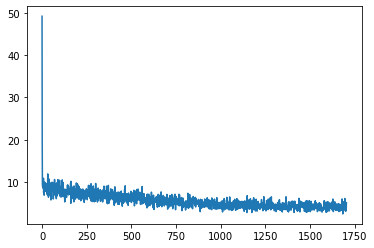

In [ ]:
# ok so for each training set we want to plot the mean of each cross validation set across the perceptrons
df = pd.read_csv('train_q1.txt',header=None).T
tensor_labels = torch.from_numpy(df[2].values)
x_train = torch.from_numpy(df.iloc[:,:2].values)
train = list(zip(x_train,tensor_labels-1))

# Initialize the loss function
learning_rate = 1e-3
#get training parameters / divide data
batch_size = int(len(train)/10)
print(batch_size)
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)

current_moving_avg=0
for n_perceptron in [1,2,4,5,6,7,8,9,10]:#validate same data for different n_perceptrons
    data_perceptron_dir =f'MLP_Training/units_{n_perceptron}/'
    os.makedirs(data_perceptron_dir,exist_ok=True)
    mean_errors = []
    print('-----------------n perceptrons',n_perceptron,'-----------')
    for leave_out_idx in range(10):
        break_cond = False
        model = NeuralNetwork(n_hidden_units=n_perceptron)
        loss_fn = nn.MSELoss()# combines softmax with loss
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        error = []
        while not break_cond:#convergence
            #print('------------------epoch---------------------')
            train_loop(train_dataloader,model,loss_fn,optimizer,leave_out_idx=leave_out_idx)
            test_error = test_loop(train_dataloader,model,loss_fn,leave_out_idx=leave_out_idx)
            error.append(test_error)
            prev_moving_avg = current_moving_avg
            if len(error)>520:
                all_moving_average =moving_average(error,500)
                #make sure moving average over many epochs settles so the averages change very little (convergence)
                break_cond = np.abs(np.mean(np.diff(all_moving_average)[-20:])) < 1e-5

        current_moving_avg = all_moving_average[-1]
        print(current_moving_avg)        
        mean_errors.append(current_moving_avg)
        plt.plot(error)
        plt.savefig(data_perceptron_dir+f'/left_out_{leave_out_idx}_plot')
        plt.show()
        torch.save(model,data_perceptron_dir+f'/left_out_{leave_out_idx}_model.pt')
    np.savetxt(data_perceptron_dir+f'/mean_errors.txt',mean_errors)

In [30]:
# get mean erros
error_dict = {}
for n_units,mean_error_path in enumerate(glob.glob('MLP_Training/*/mean_errors.txt')):
    error_dict[mean_error_path.split('/')[1]]=np.mean(np.loadtxt(mean_error_path))
error_dict

{'units_5': 4.325401832580566,
 'units_2': 6.938675404167176,
 'units_3': 5.404805592107772,
 'units_4': 4.840316124343873,
 'units_2_5': 4.3404883691787735,
 'units_1': 9.627284748935702,
 'units_6': 4.298779618453979,
 'units_8': 4.42507251777649,
 'units_9': 4.403617228889464,
 'units_7': 4.429465747499465,
 'units_10': 4.399592332339287}

In [29]:
mean_error_path.split('/')[1]

'units_10'

tensor([[ 10.4232],
        [  6.5020],
        [  5.7465],
        [  5.1492],
        [-12.4359],
        [-12.0188],
        [ -1.3289],
        [-11.0112],
        [  8.5841],
        [-10.5710],
        [ -1.2154],
        [ -0.7672],
        [-12.3117],
        [ 11.8515],
        [ -9.3774],
        [ -7.6832],
        [ 10.2758],
        [ -8.0522],
        [-10.6298],
        [  4.2224],
        [-10.9044],
        [ 14.7491],
        [ 10.9531],
        [ -0.7983],
        [ -0.6831],
        [ -9.5569],
        [ -1.2640],
        [ -1.2784],
        [-10.1729],
        [  6.1062],
        [  9.7711],
        [-13.2462],
        [-10.5779],
        [-10.3623],
        [ -0.9082],
        [ -0.9552],
        [  5.8329],
        [-10.2135],
        [ -7.9566],
        [ -0.7946],
        [ 13.9528],
        [ 14.3207],
        [-10.2401],
        [-12.4593],
        [ 12.7214],
        [ -1.0178],
        [ 10.3967],
        [  9.5302],
        [  9.8248],
        [ -1.5715],


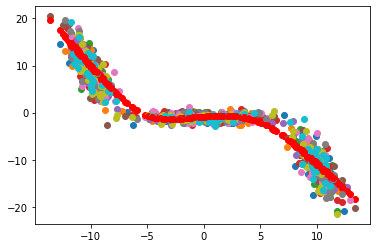

In [72]:

df = pd.read_csv('train_q1.txt',header=None).T
tensor_labels = torch.from_numpy(df[2].values)
x_train = torch.from_numpy(df.iloc[:,:2].values)
train = list(zip(x_train,tensor_labels-1))
#model = NeuralNetwork(n_hidden_units=n_perceptron)
#model()
#train[0][0].float()
model

for batch, (X, y) in enumerate(train_dataloader):
    y_hat = model(X.float())
    plt.scatter(X[:,0],y)
    plt.scatter(X[:,0],y_hat.detach(),c='r')

y_hat.reshape((100,1))


# Retrain networks with 7 units and on all data

100


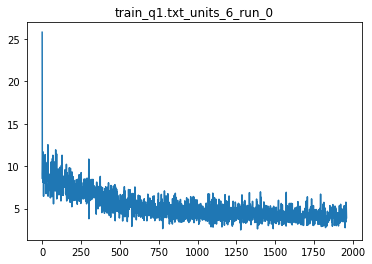

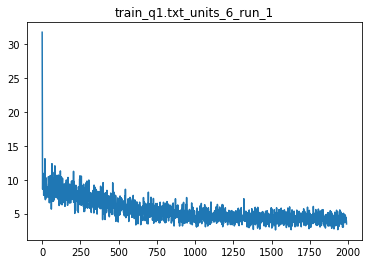

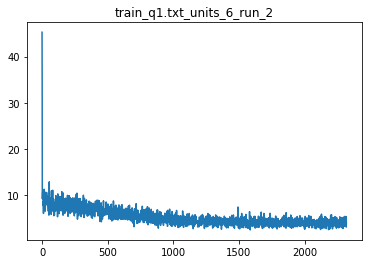

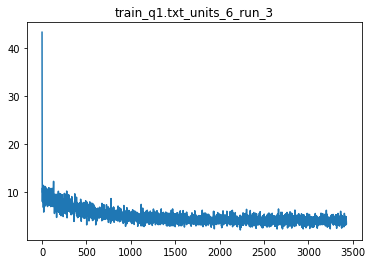

In [31]:
# data_dirs = [path.split('/')[-1] for path in sorted(glob.glob(os.path.join(mlp_train_dir,'*')))]
# unit_data_dict = dict(zip(data_dirs,[3,4,3,4,3,4]))

# for each pair we will train the neural net and test it on the training data set
# do gradient descent with all testing data (batch? th)
# we want to run each training set 4 times save them all in a new (need to make trained MLP folder)
# after ward select the best one 
n_perceptron=6
learning_rate = 1e-3
training_data='train_q1.txt'


trained_perceptron_dir =f'Trained_MLP/{training_data}_units_{n_perceptron}/'
os.makedirs(trained_perceptron_dir,exist_ok=True)

#load data
df = pd.read_csv('train_q1.txt',header=None).T
tensor_labels = torch.from_numpy(df[2].values)
x_train = torch.from_numpy(df.iloc[:,:2].values)
train = list(zip(x_train,tensor_labels-1))
batch_size = int(len(train)/10)
print(batch_size)

mean_error = []
for n_mlp in range(4):
    train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)

    break_cond = False
    model = NeuralNetwork(n_hidden_units=n_perceptron)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    error = []
    while not break_cond:#convergence
        for leave_out_idx in range(10):
            #print('------------------epoch---------------------')
            train_loop(train_dataloader,model,loss_fn,optimizer,leave_out_idx=leave_out_idx)
            test_error = test_loop(train_dataloader,model,loss_fn,leave_out_idx=leave_out_idx)
            error.append(test_error)
            if len(error)>520:
                all_moving_average =moving_average(error,500)
                #make sure moving average over many epochs settles so the averages change very little (convergence)
                break_cond = np.abs(np.mean(np.diff(all_moving_average)[-20:])) < 1e-5
    current_moving_avg = all_moving_average[-1]
    mean_error.append(current_moving_avg)
    plt.plot(error)
    plt.title(f'{training_data}_units_{n_perceptron}_run_{n_mlp}')
    plt.savefig(trained_perceptron_dir+f'training_fig_run_{n_mlp}')
    plt.show()
    torch.save(model,trained_perceptron_dir+f'run_{n_mlp}.pt')
np.savetxt(trained_perceptron_dir+'run_mean_errors',mean_error)

In [15]:
mean_error

[4.04213464307785, 4.141933769702911, 4.040237851142884, 4.020728457450867]

# Test data specific trained MLP on test data

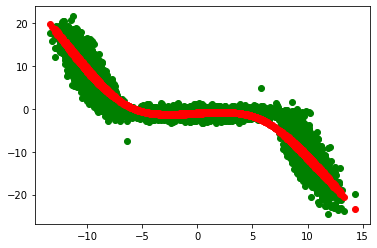

In [68]:
#load testing data
#load data
df = pd.read_csv('test_q1.txt',header=None).T
tensor_labels = torch.from_numpy(df[2].values)
x_test= torch.from_numpy(df.iloc[:,:2].values)
test_data = list(zip(x_test,tensor_labels-1))
test_data_loader = DataLoader(test_data, batch_size=10000)

trained_perceptron_dir =f'Trained_MLP/{training_data}_units_{n_perceptron}/'

# load errors get min 
model_mean_errors = np.loadtxt(trained_perceptron_dir + 'run_mean_errors')
min_model_run = np.argmin(model_mean_errors)

# # load model corresponnding to min
min_model_data = torch.load(trained_perceptron_dir+f'run_{min_model_run}.pt')
min_model_data.eval()
test_loss = nn.MSELoss()
# #make predictions
for batch, (X, y) in enumerate(test_data_loader):
    y_hat = min_model_data(X.float())
    #plt.scatter(X[:,0],y,c='g')
    plt.scatter(X[:,0],y,c='g')
    plt.scatter(X[:,0],y_hat.detach(),c='r')

# y_hat.reshape((100,1))


In [61]:
np.mean(np.square(y_hat.detach().numpy().reshape(10000)-y.numpy()))

4.220581321205188

# Ensure library does what we want

In [14]:
class ToyNeuralNetwork(nn.Module):
    def __init__(self):
        super(ToyNeuralNetwork, self).__init__()
        self.linear = torch.nn.Linear(1, 1)

    def forward(self, x):
        out = self.linear(x)
        return out

In [47]:
toy_model = ToyNeuralNetwork()
toy_loss_fn = torch.nn.MSELoss()
toy_optimizer = torch.optim.SGD(toy_model.parameters(), lr=1e-4)

In [48]:
x_toy= torch.from_numpy(np.random.randn(100,1))
y_toy = torch.from_numpy(np.dot(x_toy,[.5]))

In [52]:
for i in range(20000):
            # Compute prediction and loss
            pred = toy_model(x_toy.float())#convert X to float 32 not 64
            toy_loss = toy_loss_fn(pred,y_toy.float().reshape((100,1)))
            #print(toy_loss)
            toy_optimizer.zero_grad()
            toy_loss.backward()
            toy_optimizer.step()

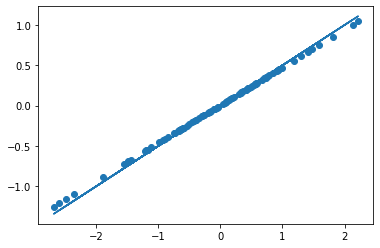

In [53]:
plt.plot(x_toy,y_toy)
plt.scatter(x_toy,pred.detach())

# Look at Min p(error)

In [36]:
# ok so for each training set we want to plot the mean of each cross validation set across the perceptrons
mlp_train_dir = '/Users/mcveigh.k/Desktop/classes/Spring_2021/ML_Spring_2021/code/Assignment3/ipynb/MLP_Training/'
data_dirs = [path.split('/')[-1] for path in sorted(glob.glob(os.path.join(mlp_train_dir,'*')))]
unit_data_dict = dict(zip(data_dirs,[3,4,3,4,3,4]))

min_error_dict = {}
for train_data_path in sorted(glob.glob(os.path.join(mlp_train_dir,'*'))):
    error_dict = {}
    for unit_idx, mean_error_path in enumerate(glob.glob(os.path.join(train_data_path,'*','*mean*'))):
        #print(mean_error_path)
        n_units_str = mean_error_path.split('/')[-2].split('_')[1]
        error_dict[int(n_units_str)]=np.mean(np.loadtxt(mean_error_path))
    argmin_idx = np.argmin(list(error_dict.values()))
    min_error_dict[train_data_path.split('/')[-1]]=list(error_dict.keys())[argmin_idx]
min_error_dict

{'1000_question_data': 7,
 '100_question_data': 10,
 '2000_question_data': 9,
 '200_question_data': 10,
 '5000_question_data': 10,
 '500_question_data': 8}

100


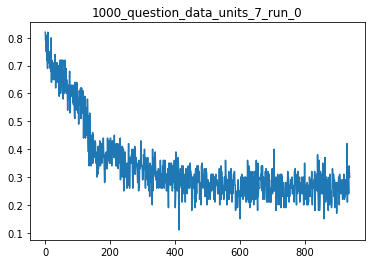

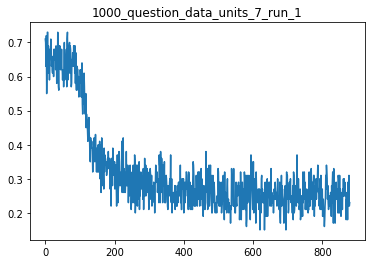

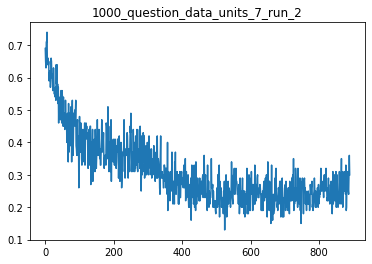

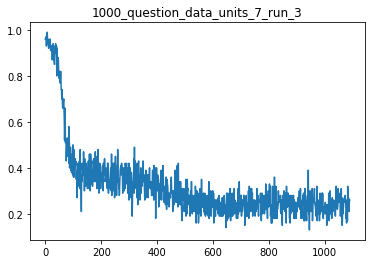

10


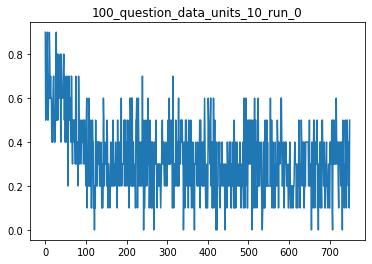

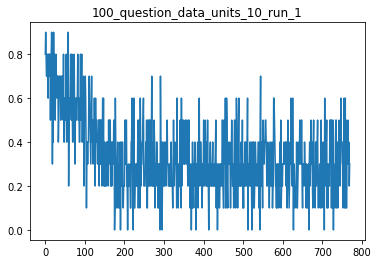

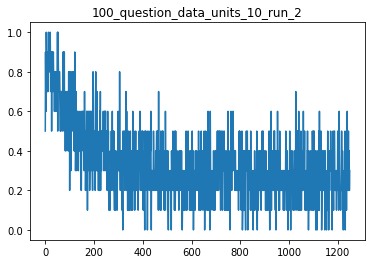

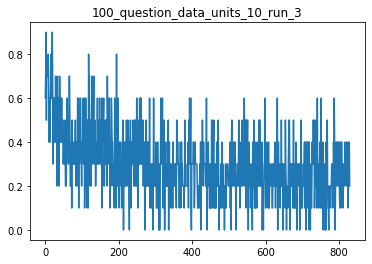

200


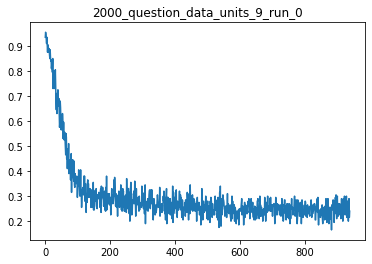

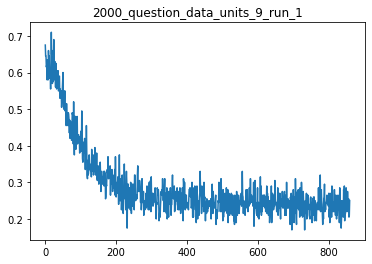

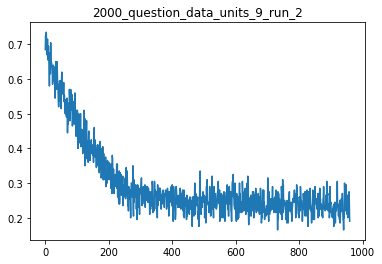

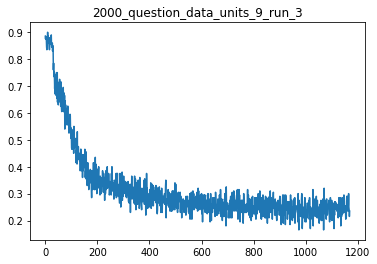

20


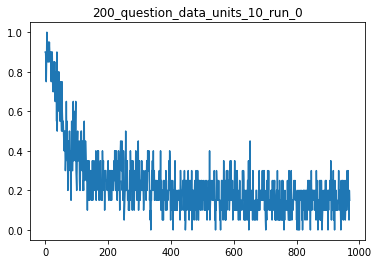

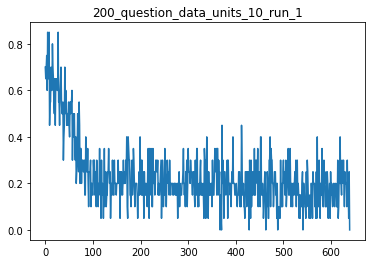

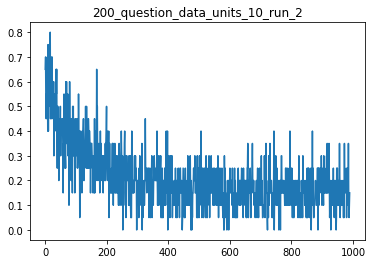

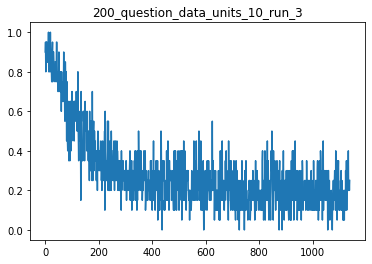

500


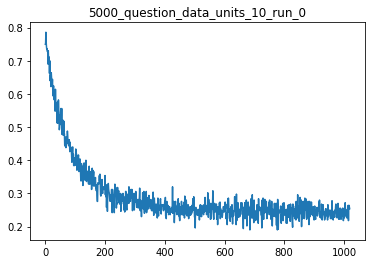

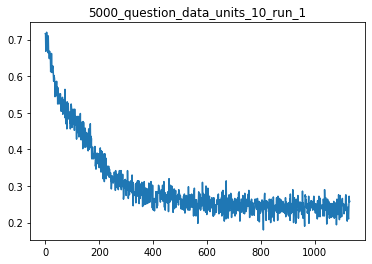

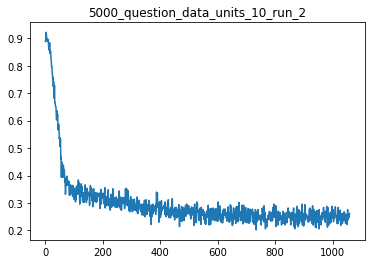

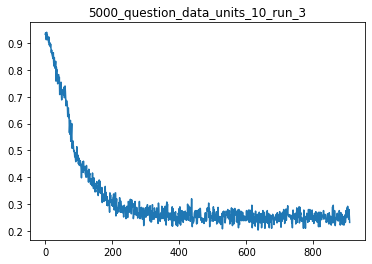

50


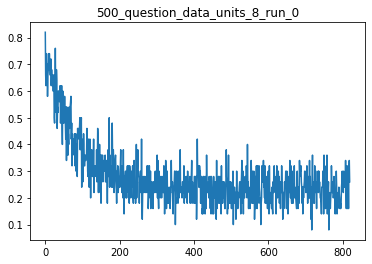

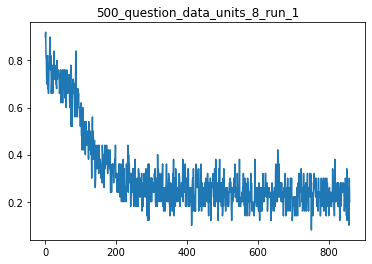

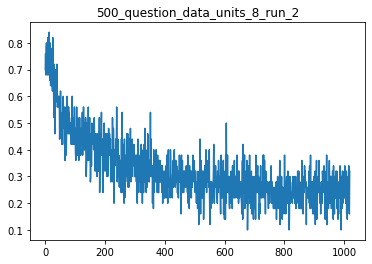

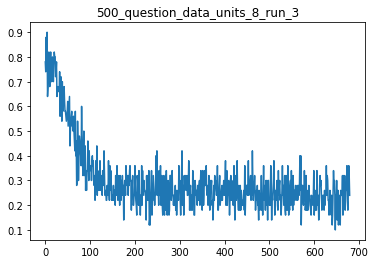

In [44]:

for training_data,n_perceptron in min_error_dict.items():

    trained_perceptron_dir =f'Trained_MLP_min_error/{training_data}_units_{n_perceptron}/'
    os.makedirs(trained_perceptron_dir,exist_ok=True)

    #load data
    
    train = LoadData(training_data)
    batch_size = int(len(train)/10)
    print(batch_size)
    mean_error = []
    for n_mlp in range(4):
        train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)

        break_cond = False
        model = NeuralNetwork(n_hidden_units=n_perceptron)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        error = []
        while not break_cond:#convergence
            for leave_out_idx in range(10):
                #print('------------------epoch---------------------')
                train_loop(train_dataloader,model,loss_fn,optimizer,leave_out_idx=leave_out_idx)
                test_error = test_loop(train_dataloader,model,loss_fn,leave_out_idx=leave_out_idx)
                error.append(test_error)
                if len(error)>520:
                    all_moving_average =moving_average(error,500)
                    #make sure moving average over many epochs settles so the averages change very little (convergence)
                    break_cond = np.abs(np.mean(np.diff(all_moving_average)[-20:])) < 1e-5
        current_moving_avg = all_moving_average[-1]
        mean_error.append(current_moving_avg)
        plt.plot(error)
        plt.title(f'{training_data}_units_{n_perceptron}_run_{n_mlp}')
        plt.savefig(trained_perceptron_dir+f'training_fig_run_{n_mlp}')
        plt.show()
        torch.save(model,trained_perceptron_dir+f'run_{n_mlp}.pt')
    np.savetxt(trained_perceptron_dir+'run_mean_errors',mean_error)

In [49]:
#load testing data
test_data_path='100000_question_data'
test_data = LoadData(test_data_path)
test_data_loader = DataLoader(test_data, batch_size=10000)

test_error_dict = {}

data_dirs = [path.split('/')[-1] for path in sorted(glob.glob(os.path.join(mlp_train_dir,'*')))]
unit_data_dict = dict(zip(data_dirs,[4,4,3,4,3,4]))

for training_data,n_perceptron in unit_data_dict.items():
    trained_perceptron_dir =f'Trained_MLP/{training_data}_units_{n_perceptron}/'

    # load errors get min 
    model_mean_errors = np.loadtxt(trained_perceptron_dir + 'run_mean_errors')
    min_model_run = np.argmin(model_mean_errors)

    # load model corresponnding to min
    min_model_data = torch.load(trained_perceptron_dir+f'run_{min_model_run}.pt')
    min_model_data.eval()
    test_loss = nn.CrossEntropyLoss()
    #make predictions
    correct =0
    for x,y in test_data_loader:
        pred = min_model_data(x.float())
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    acc = (correct)/len(test_data_loader.dataset)
    test_error_dict[training_data]= 1-acc

test_min_error_dict ={}    
for training_data,n_perceptron in min_error_dict.items():
    trained_perceptron_dir =f'Trained_MLP_min_error/{training_data}_units_{n_perceptron}/'

    # load errors get min 
    model_mean_errors = np.loadtxt(trained_perceptron_dir + 'run_mean_errors')
    min_model_run = np.argmin(model_mean_errors)

    # load model corresponnding to min
    min_model_data = torch.load(trained_perceptron_dir+f'run_{min_model_run}.pt')
    min_model_data.eval()
    test_loss = nn.CrossEntropyLoss()
    #make predictions
    correct =0
    for x,y in test_data_loader:
        pred = min_model_data(x.float())
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    acc = (correct)/len(test_data_loader.dataset)
    test_min_error_dict[training_data]= 1-acc

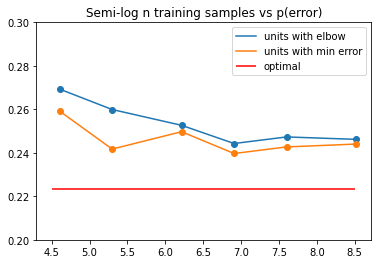

In [55]:
# elbow method
int_dict = {}
for key in test_error_dict.keys():
    int_dict[int(key.split('_')[0])]=test_error_dict[key]
sorted_error_dict = dict(sorted(int_dict.items()))

plt.plot(np.log(list(sorted_error_dict.keys())),
         sorted_error_dict.values(), label='units with elbow')
plt.scatter(np.log(list(sorted_error_dict.keys())),
         sorted_error_dict.values())
# min error
int_dict = {}
for key in test_min_error_dict.keys():
    int_dict[int(key.split('_')[0])]=test_min_error_dict[key]
sorted_error_dict = dict(sorted(int_dict.items()))

plt.plot(np.log(list(sorted_error_dict.keys())),
         sorted_error_dict.values(), label='units with min error')
plt.scatter(np.log(list(sorted_error_dict.keys())),
         sorted_error_dict.values())
plt.hlines(.2233,4.5,8.5,colors='r',label='optimal')
plt.ylim([0.2,.3])
plt.title('Semi-log n training samples vs p(error)')
plt.legend()

In [20]:
clf = MLPClassifier(random_state=1, max_iter=2000,hidden_layer_sizes=(30,))
clf.fit(test[:,:3], test[:,3])
clf.score(test[:,:3], test[:,3])


0.77676

#### 